<a href="https://colab.research.google.com/github/DUNGTK2004/Deep-learning-homework/blob/main/MLP_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 1024
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


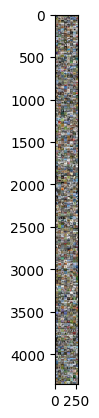

ship  deer  frog  deer  cat   car   frog  deer  bird  car   bird  car   deer  plane plane truck frog  deer  deer  truck car   car   deer  bird  dog   cat   car   cat   car   dog   truck frog  ship  horse frog  truck dog   cat   car   cat   frog  car   ship  dog   frog  deer  cat   car   truck cat   plane car   plane horse bird  bird  truck bird  horse bird  cat   cat   plane car   plane horse ship  frog  truck dog   deer  dog   dog   cat   cat   frog  truck deer  truck plane ship  bird  horse dog   bird  cat   ship  truck bird  horse horse frog  cat   horse cat   dog   deer  plane dog   deer  cat   cat   plane deer  cat   dog   truck ship  car   horse deer  plane deer  truck bird  truck bird  cat   truck deer  deer  cat   truck dog   plane ship  frog  ship  cat   cat   ship  dog   plane deer  plane dog   ship  car   cat   cat   horse dog   car   car   deer  truck horse car   car   ship  plane dog   horse deer  car   cat   horse car   deer  deer  cat   car   bird  truck bird  frog  deer

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [ ]:
class MLP(nn.Module):
  def __init__(self, n_hidden1, n_hidden2, n_class):
    super(MLP, self).__init__()
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(3 * 32 * 32, n_hidden1)
    self.Lrelu1 = nn.LeakyReLU(negative_slope=0.15)
    self.fc2 = nn.Linear(n_hidden1, n_hidden2)
    self.Lrelu2 = nn.LeakyReLU(negative_slope=0.15)
    self.fc3 = nn.Linear(n_hidden2, n_class)
  def forward(self, img):
    out = self.flat(img)
    out = self.fc1(out)
    out = self.Lrelu1(out)
    out = self.fc2(out)
    out = self.Lrelu2(out)
    out = self.fc3(out)
    return out



100%|██████████| 100/100 [18:25<00:00, 11.05s/it]


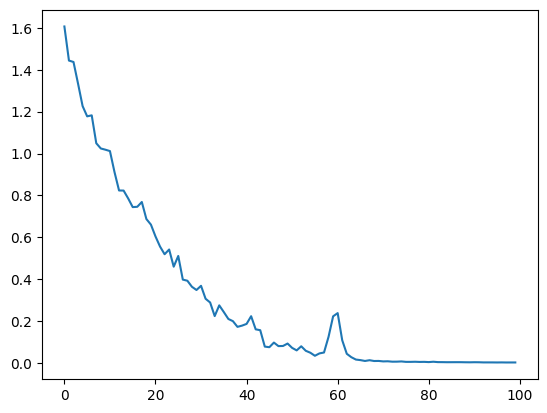

In [ ]:
import tqdm
hidden1 = 256
hidden2 = 512
n_class = 10
model = MLP(hidden1, hidden2, n_class).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epoch = 100
losses = []
def train():
  for epoch in tqdm.trange(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      inputs, labels = data[0].to('cuda'), data[1].to('cuda')
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    losses.append(loss.item())
  plt.plot(losses)

train()



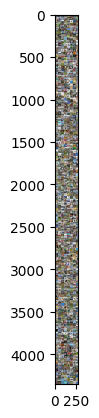

groundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  


In [ ]:
#Test
dataiter = iter(testloader)
images, labels = next(dataiter)

#print image
imshow(torchvision.utils.make_grid(images))
print("groundTruth: ", ' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [ ]:
#save model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to('cuda'), data[1].to('cuda')
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct //total} %')

Accuracy of the network on the 10000 test images: 54 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to('cuda'), data[1].to('cuda')
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.8 %
Accuracy for class: car   is 62.0 %
Accuracy for class: bird  is 42.5 %
Accuracy for class: cat   is 36.5 %
Accuracy for class: deer  is 48.9 %
Accuracy for class: dog   is 44.7 %
Accuracy for class: frog  is 59.3 %
Accuracy for class: horse is 57.9 %
Accuracy for class: ship  is 69.8 %
Accuracy for class: truck is 58.8 %
